# Prelims

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

/Users/adamschiller/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'
CSV = PATH/'words.csv'

# !ls {PATH}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Helpers

In [5]:
def nonzero(pred):
    ints = to_np(pred).astype(int)
    return ints[np.nonzero(ints)]

def char_label_text(pred):
    return ''.join([itos[i] for i in nonzero(pred)])

def char_split_text(pred):
    return [itos[i] for i in nonzero(pred)]

def word_label_text(pred):
    return ' '.join([w_itos[i] for i in nonzero(pred)])

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    if title: ax.set_title(title)
    return ax

# Data

## 3x1

In [7]:
fname = 'synth_words_50000.csv' if device.type == 'cuda' else 'synth_words.csv'
CSV = PATH/fname
FOLDER = 'synth_words'

csv = pd.read_csv(CSV)
len(csv)

10000

In [8]:
sz,bs = (64,120) if device.type == 'cpu' else (128,100)
seq_len = 45
stats = (np.array([0.90382, 0.90382, 0.90382]), np.array([0.19798, 0.19798, 0.19798]))  # inception_stats

## 3x2

In [82]:
fname = 'multi_synth_words_50000.csv' if device.type == 'cuda' else 'multi_synth_words.csv'
CSV = PATH/fname
FOLDER = 'multi_synth_words'

csv = pd.read_csv(CSV)
len(csv)

50000

In [83]:
sz,bs = 256,60
seq_len = 75
stats = (np.array([0.93186, 0.93186, 0.93186]), np.array([0.17579, 0.17579, 0.17579]))

## Large

In [ ]:
CSV = PATH/'large_synth_words_50000.csv'
FOLDER = 'large_synth_words'

csv = pd.read_csv(CSV)
len(csv)

In [ ]:
sz,bs = 400,30
seq_len = 150
stats = (np.array([0.93186, 0.93186, 0.93186]), np.array([0.17579, 0.17579, 0.17579]))

## ModelData

In [9]:
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

val_idxs = np.array(csv.sample(frac=0.15).index)

In [17]:
f = resnet34

aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]
# tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, FOLDER, CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [18]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

## Verify Data

In [28]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.trn_dl))
imgs = denorm(x)

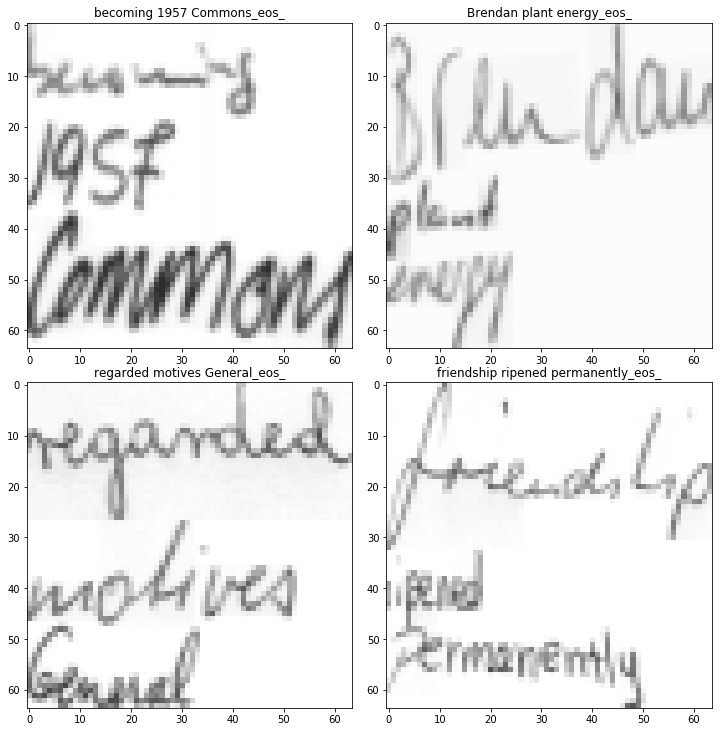

In [29]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = char_label_text(y[i])
    ax=show_img(imgs[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

In [22]:
aug_names = data.aug_dl.dataset.fnames

In [23]:
val_names = data.val_dl.dataset.fnames

In [24]:
aug_names == val_names

array([ True,  True,  True, ...,  True,  True,  True])

In [25]:
trn_names = data.trn_dl.dataset.fnames

In [27]:
aug_names[0] in trn_names

False

# Loss and Metrics

In [37]:
def loss_prep(input, target):
    "equalize input/target sl; combine bs/sl dimensions"
    bs,tsl = target.shape
    _ ,sl,vocab = input.shape
        
    # F.pad( front,back for dimensions: 1,0,2 )
    if sl>tsl: target = F.pad(target, (0,sl-tsl))
    if tsl>sl: target = target[:,:sl]
#     if tsl>sl: input = F.pad(input, (0,0,0,0,0,tsl-sl))
        
    targ = target.contiguous().view(-1).long()
    pred = input.contiguous().view(-1, vocab)
    return pred, targ

In [38]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        
    def forward(self, pred, target):
        pred,targ = loss_prep(pred, target)
        pred = F.log_softmax(pred, dim=-1)  # need this for KLDivLoss
        true_dist = pred.data.clone()
        true_dist.fill_(self.smoothing / pred.size(1))                  # fill with 0.0012
        true_dist.scatter_(1, targ.data.unsqueeze(1), self.confidence)  # [0.0012, 0.0012, 0.90, 0.0012]
        return F.kl_div(pred, true_dist, reduction='sum')/bs

In [39]:
def XE_loss(input, target):    # takes logits
    pred,targ = loss_prep(input, target)
    return F.cross_entropy(pred, targ, reduction='sum')/bs

In [70]:
def Focal_loss(input, target):
    pred,targ = loss_prep(input, target)
    wgt = get_weight(pred, targ)
    wgt = wgt.mean(0)   # This seems naively logical but probably a terrible idea... 
    return F.cross_entropy(pred, targ, weight=wgt, reduction='sum')/bs
    
def get_weight(p,t):
    t = one_hot_encode(p,t)
    alpha,gamma = 0.25,1
    p = p.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)

def one_hot_encode(p,t):
    hot = torch.zeros_like(p)
    return hot.scatter_(1, t.data.unsqueeze(1), 1)

In [41]:
def KL_loss(input, target):    # takes log probabilities (LogSoftmax)
    pred,targ = loss_prep(input, target)
    pred = F.log_softmax(pred, dim=-1)
    return F.kl_div(pred, targ, reduction='sum')/bs

In [42]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))/len(w1)

In [43]:
def char_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([bs, sl, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = char_label_text(res[i])
        t = char_label_text(targs[i])
        error += cer(t,p)
    return error/bs

def word_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([bs, sl, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = word_label_text(res[i])
        t = word_label_text(targs[i])
        error += wer(t,p)
    return error/bs

# Transformer Architecture

In [44]:
# similar to batchnorm but on a layer level
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [45]:
class SublayerConnection(nn.Module):
    "A residual connection followed by a layer norm.  Note: (for code simplicity) norm is first."
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [46]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [47]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [48]:
class EncoderLayer(nn.Module):
    "Encoder: self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)

    def forward(self, x):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        return self.sublayer[1](x, self.feed_forward)

In [49]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, src, tgt_mask=None):
        for layer in self.layers:
            x = layer(x, src, tgt_mask)
        return self.norm(x)

In [50]:
class DecoderLayer(nn.Module):
    "Decoder: self-attn, src-attn, and feed forward"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)  # wraps layer in residual,dropout,norm
 
    def forward(self, x, src, tgt_mask=None):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, src, src))
        return self.sublayer[2](x, self.feed_forward)

In [51]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    depth = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(depth)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)    
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [52]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, q, k, v, mask=None):
        if mask is not None: mask = mask.unsqueeze(1)
        bs = q.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        q, k, v = [l(x).view(bs, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (q, k, v))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(q, k, v, mask=mask, dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(bs, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [53]:
class SingleHeadedAttention(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super(SingleHeadedAttention, self).__init__()
        self.linears = clones(nn.Linear(d_model, d_model), 3)
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):        
        query, key, value = [l(x) for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        return x

In [54]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_model*2)  # CHANGES 4 -> 2
        self.w_2 = nn.Linear(d_model*2, d_model)  # CHANGES 4 -> 2
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.leaky_relu(self.w_1(x))))  # CHANGES relu -> leaky_relu

In [55]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0.0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)
    
# class Embeddings(nn.Module):
#     def __init__(self, d_model, vocab):
#         super(Embeddings, self).__init__()
#         self.lut = nn.Embedding(vocab, d_model)
#         self.d_model = d_model

#     def forward(self, x):
#         return self.lut(x) * math.sqrt(self.d_model)

In [56]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, tgt_mask=None):
        return self.decode(self.encode(src), tgt, tgt_mask)
    
    def encode(self, src):
        return self.encoder(src)
    
    def decode(self, src, tgt, tgt_mask=None):
        return self.decoder(self.tgt_embed(tgt), src, tgt_mask)
    
    def generate(self, outs):
        return self.generator(outs)

# Img2seq Arch

In [57]:
class ResnetBase(nn.Module):
    def __init__(self, em_sz, d_model):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[em_sz]
        net = f(True)
        modules = list(net.children())[:s]
        self.base = nn.Sequential(*modules)
        self.linear = nn.Linear(em_sz, d_model)
        
    def forward(self, img):
        x = self.base(img).flatten(2,3).transpose(2,1)
        return self.linear(x) * math.sqrt(x.size(-1))        # bs,area,d_model

In [58]:
def make_custom_model(vocab, d_model=512, N=2, h=1, dropout=0.3):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
#     attn = SingleHeadedAttention(d_model)
    ff = PositionwiseFeedForward(d_model, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(nn.Embedding(vocab, d_model), position),
        #nn.Sequential(Embeddings(d_model, src_vocab), position),
        nn.Linear(d_model, vocab)
    )
        
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
            #nn.init.kaiming_normal_(p)  # better for use w/ relu activations
            # the resnet base is initialized w/ kaiming_normal
                    
    return model

In [59]:
class Img2Seq(nn.Module):
    def __init__(self, img_encoder, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_encoder
        self.transformer = transformer
        
    def forward(self, src, tgt=None, tgt_mask=None):
        feats = self.img_enc(src)                            # ([bs, h*w, em_sz])        
        dec_outs = self.transformer(feats, tgt, tgt_mask)    # ([bs, sl, d_model])
        out = self.transformer.generate(dec_outs)            # ([bs, sl, vocab])
        return out

    def greedy_decode(self, src, seq_len):
        feats = self.img_enc(src)
        bs = src.size(0)
        tgt = torch.ones((bs,1), dtype=torch.long, device=device)

        res = []
        for i in range(seq_len):
            dec_outs = self.transformer(feats, Variable(tgt))
            prob = self.transformer.generate(dec_outs[:,-1])
            res.append(prob)
            pred = torch.argmax(prob, dim=-1, keepdim=True)
            if (pred==0).all(): break
            tgt = torch.cat([tgt,pred], dim=-1)
        out = torch.stack(res).transpose(1,0).contiguous()
        return out      

In [71]:
d_model = 512
em_sz = 128 if device.type == 'cpu' else 256
img_encoder = ResnetBase(em_sz, d_model)
transformer = make_custom_model(len(itos), d_model)
net = Img2Seq(img_encoder, transformer)

opt_fn = partial(optim.Adam, betas=(0.7, 0.99)) #, lr=0, betas=(0.9, 0.98), eps=1e-9)
# model_opt = NoamOpt(d_model, 2, 400, optim.Adam(net.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
# steps: [1e-5, 2e-5, 3e-5, 4e-5... Ne-4]

learn = RNN_Learner(data, SingleModel(to_gpu(net)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = Focal_loss #LabelSmoothing(smoothing=0.1)   #XE_loss  #Focal_loss
learn.metrics = [char_error_rate]

# Stepper

In [61]:
def subsequent_mask(size):
    attn_shape = torch.ones((size,size), dtype=torch.uint8, device=device)
    mask = torch.tril(attn_shape).unsqueeze(0)
    return mask

def make_tgt_mask(tgt, pad=0):
    "Create a mask to hide padding and future words."
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return tgt_mask

In [62]:
def rshift(tgt, token=1):
    "Shift y to the right by prepending token"
    return torch.cat((torch.ones((tgt.size(0),token), device=device), tgt[:,:-1]), dim=-1)

In [63]:
class TfmrStepper(Stepper):
    def step(self, xs, y, epoch):
#         self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
    
        # without BOS token:
        shifted_y = rshift(y).long()
        tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)
        output = self.m(*xs, shifted_y, tgt_mask)
        
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()        
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm_(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.item()
    
    def evaluate(self, xs, y):
        shifted_y = rshift(y).long()
        tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)
        preds = self.m(*xs, shifted_y, tgt_mask)
        if isinstance(preds,tuple): preds=preds[0]
        return preds, self.crit(preds, y)

# Train

## LR find

 48%|████▊     | 340/709 [02:30<02:43,  2.26it/s, loss=62.2]

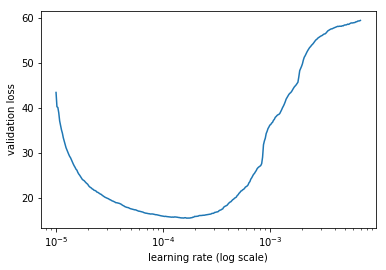

In [62]:
learn.lr_find(stepper=TfmrStepper)
learn.sched.plot(n_skip=0, n_skip_end=2)

## Fit

In [72]:
#cpu
lr=1e-3
learn.fit(lr, 1, cycle_len=1, stepper=TfmrStepper)

# 70.06133   56.057642  0.84744  ~6:23   vanilla arch (sequential rnn)
# 108.58607  96.216297  1.0      ~20:18  sequential transformer w/ orig Attention
# 63.44471   57.404668  0.798303 ~4:22   (2nd run) transformer

  0%|          | 0/71 [00:00<?, ?it/s]> <ipython-input-70-74d54e45b966>(5)Focal_loss()
-> return F.cross_entropy(pred, targ, weight=wgt, reduction='sum')/bs
(Pdb) wgt.shape
torch.Size([3840, 82])
(Pdb) wgt.mean(0)
tensor([0.3255, 0.2315, 0.3303, 0.2900, 0.3716, 0.2178, 0.1577, 0.5196, 0.5618,
        0.0881, 0.3437, 0.5362, 0.2756, 0.5730, 0.3082, 0.3978, 0.4233, 0.4561,
        0.3205, 0.5654, 0.2426, 0.2782, 0.5707, 0.3077, 0.4130, 0.3772, 0.4844,
        0.3592, 0.3272, 0.4065, 0.3955, 0.3587, 0.2857, 0.1367, 0.5252, 0.3401,
        0.3902, 0.4551, 0.5269, 0.3867, 0.1267, 0.3544, 0.2498, 0.3831, 0.3299,
        0.3431, 0.4385, 0.3294, 0.3789, 0.3738, 0.3878, 0.3261, 0.4365, 0.5124,
        0.3880, 0.2313, 0.2094, 0.4576, 0.4637, 0.3964, 0.2324, 0.5021, 0.3459,
        0.2252, 0.5793, 0.6384, 0.2714, 0.4481, 0.4300, 0.2811, 0.3882, 0.5161,
        0.3717, 0.6092, 0.3962, 0.2500, 0.4309, 0.4552, 0.4118, 0.2813, 0.2191,
        0.5225], grad_fn=<MeanBackward0>)
(Pdb) wgt.std(0)
tensor(

BdbQuit: 

In [51]:
#gpu
lr=1e-4
learn.fit(lr, 5, cycle_len=1, stepper=TfmrStepper, use_clr=(20,5))
# First try: XE/bs, kaiming_normal, no pos_enc, emb/out weight tying, no encoder, 2 layers, 256/256, single attn
# 52.199187  50.1736    0.730092    lr:1e-4
# 17.318725  13.803769  0.205331    2nd run, lr: 1e-3
# 11.96539   9.991971   0.151522    3rd run, lr: 1e-4     **tfmr

# Loss fns
# 43.177135  41.245482  1.185836    LabelSmoothing (KL/bs)
# 4215.8745  4012.3099  0.957795    LabelSmoothing (KL)
# 45.200728  43.662235  0.753881    LabelSmoothing (KL/bs w/out padding logic)  perplexity < BLEU/acc
# 5340.5770  5129.8346  0.738853    XE                    --- scaling by BS not a factor
# 52.199187  50.1736    0.730092    XE/bs  **

# Initialization/Activation
# 52.199187  50.1736    0.730092    kaiming_normal  (ff activation: leaky_relu)
# 52.987157  50.976083  0.758013    kaiming_uniform
# 49.553779  47.270616  0.702353    xavier_normal
# 49.380884  47.345175  0.673508    xavier_uniform  (ff activation: leaky_relu)   **
# 49.849071  47.369221  0.708807    xavier_uniform  (ff activation: relu)

# Positional Encoding
# 35.426869  30.449724  0.423573    target only; no embed/out weight tying   **
# 35.390268  31.216677  0.45097     "" ; w/ scaling factor [* math.sqrt(d_model)]
# 45.596748  42.213515  0.572662    target only; w/ embed/out weight tying

# Encoder
# 34.46771   29.207974  0.408425    **

# Attention
# 32.087941  26.431674  0.362717    SingleHead - linear layers for (q,k,v)
# 37.739475  32.962685  0.454753    MultiHead (8)
# 36.09057   31.346036  0.432342    MultiHead (4)
# 31.069687  26.00539   0.360032    MultiHead (1)     **

# N layers (6)
# 51.119606  48.809905  0.645302

# d_model = 512
# 21.032752  17.234559  0.230763    ~11:35  **

# em_sz
# 27.589121  22.698359  0.307399    128  ~14:09
# 28.320952  24.183105  0.338207    512  ~11:31

# include layer_norm in encoder/decoder
# 24.035412  19.824303  0.270881   modified: self.norm(x + self.dropout(sublayer(x)))
# 20.347157  17.23408   0.228328   original:  x + self.dropout(sublayer(self.norm(x)))   **tfmr_experiment
# 10.732795  9.875141   0.12633    2nd run

epoch      trn_loss   val_loss   char_error_rate            
    0      17.590374  14.335624  0.188566  
    1      15.350214  12.794923  0.16602                    
    2      13.510983  11.572885  0.148609                   
    3      12.076797  10.616214  0.136213                   
    4      10.732795  9.875141   0.12633                    



[9.875141385396322, 0.12632963641074316]

In [52]:
learn.save('tfmr_experiment')

In [50]:
learn.load('tfmr_experiment')

# Increase size

In [99]:
sz,bs = 400,45

In [61]:
learn.set_data(data)

 72%|███████▏  | 511/709 [05:47<02:14,  1.47it/s, loss=517]

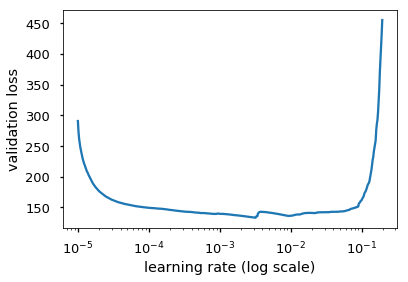

In [95]:
learn.lr_find(stepper=TfmrStepper)
learn.sched.plot(n_skip=0, n_skip_end=2)

In [96]:
learn.load('tfmr_3x1_256')

In [109]:
lr=1e-4
learn.fit(lr, 5, cycle_len=1, stepper=TfmrStepper, use_clr=(20,5))
# 3x1; sz: 256
# 8.169301   7.199782   0.087933    fresh start
# 4.305115   4.585243   0.054132    2nd run (increase dropout 0.2)   **tfmr_3x1_256

# 3.6729     3.756866   0.047393    resize from 128

# 3x2; sz:256
# 14.65408   13.10881   0.090017    preload tfmr_3x1_256
# 5.701717   5.83973    0.039572    resize 256 > 400 (increase dropout 0.3)  **tfmr_3x2

epoch      trn_loss   val_loss   char_error_rate             
    0      10.281358  8.268097   0.055719  
    1      8.776536   7.217093   0.0486                      
    2      7.36242    6.583913   0.044425                    
    3      6.523849   6.056916   0.040771                    
    4      5.701717   5.83973    0.039572                    


[5.839730494036646, 0.03957212774947661]

In [110]:
learn.save('tfmr_3x2')

# Results

In [41]:
learn.load('tfmr_experiment')

In [111]:
x,y = next(iter(data.val_dl))

shifted_y = rshift(y).long()
tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)

learn.model.eval()
preds = learn.model(x, shifted_y, tgt_mask)
res = torch.argmax(preds, dim=-1)

In [112]:
learn.crit(preds, y)
# baseline - random: 13899.34

tensor(4.1124, device='cuda:0', grad_fn=<DivBackward0>)

In [113]:
char_error_rate(preds, y)
# baseline - random: 2.12

0.03909144066009012

## Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


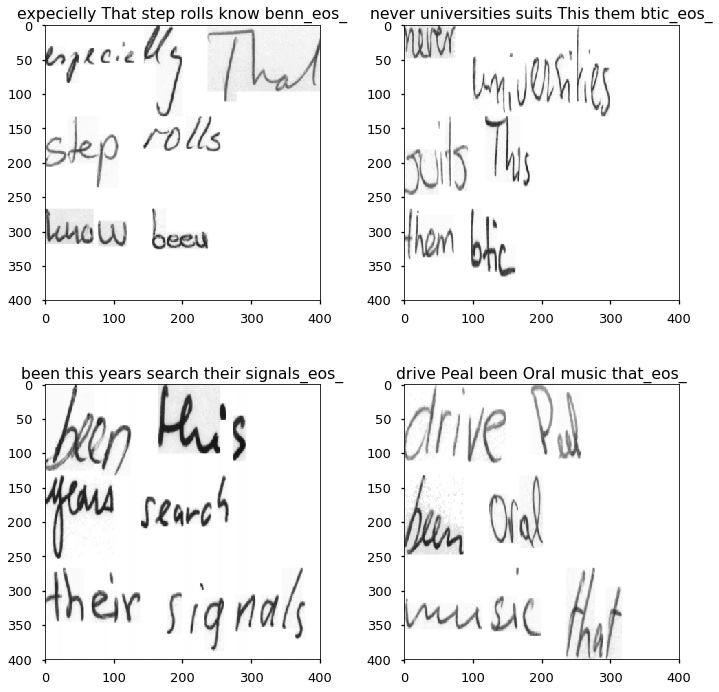

In [118]:
imgs = data.val_ds.denorm(x)

fig, axes = plt.subplots(2,2, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    p = char_label_text(res[i])
    ax=show_img(imgs[i], ax=ax, title=p)
    
plt.tight_layout(pad=0.1)

# Visualize Attention

In [119]:
def self_attn(layer=-1): return learn.model.transformer.decoder.layers[layer].self_attn.attn
def source_attn(layer=-1): return learn.model.transformer.decoder.layers[layer].src_attn.attn

In [120]:
src_attn = source_attn()
src_attn.shape

torch.Size([45, 1, 56, 625])

In [57]:
# conv
k = 16
def torch_scale_attns(attns):
    bs,sl,_ = attns.shape
    num = sz // k
    mod = attns.view(bs,sl,num,num)
    scaled = torch.nn.functional.interpolate(mod, size=sz)
    return scaled  #([bs, sl, sz, sz])

In [58]:
from scipy.ndimage import gaussian_filter

def g_filter(att):
    return gaussian_filter(att, sigma=k)

In [121]:
idx = 1
img = imgs[idx]
pred = res[idx]
img_attns = to_np(torch_scale_attns(src_attn.squeeze(1))[idx])

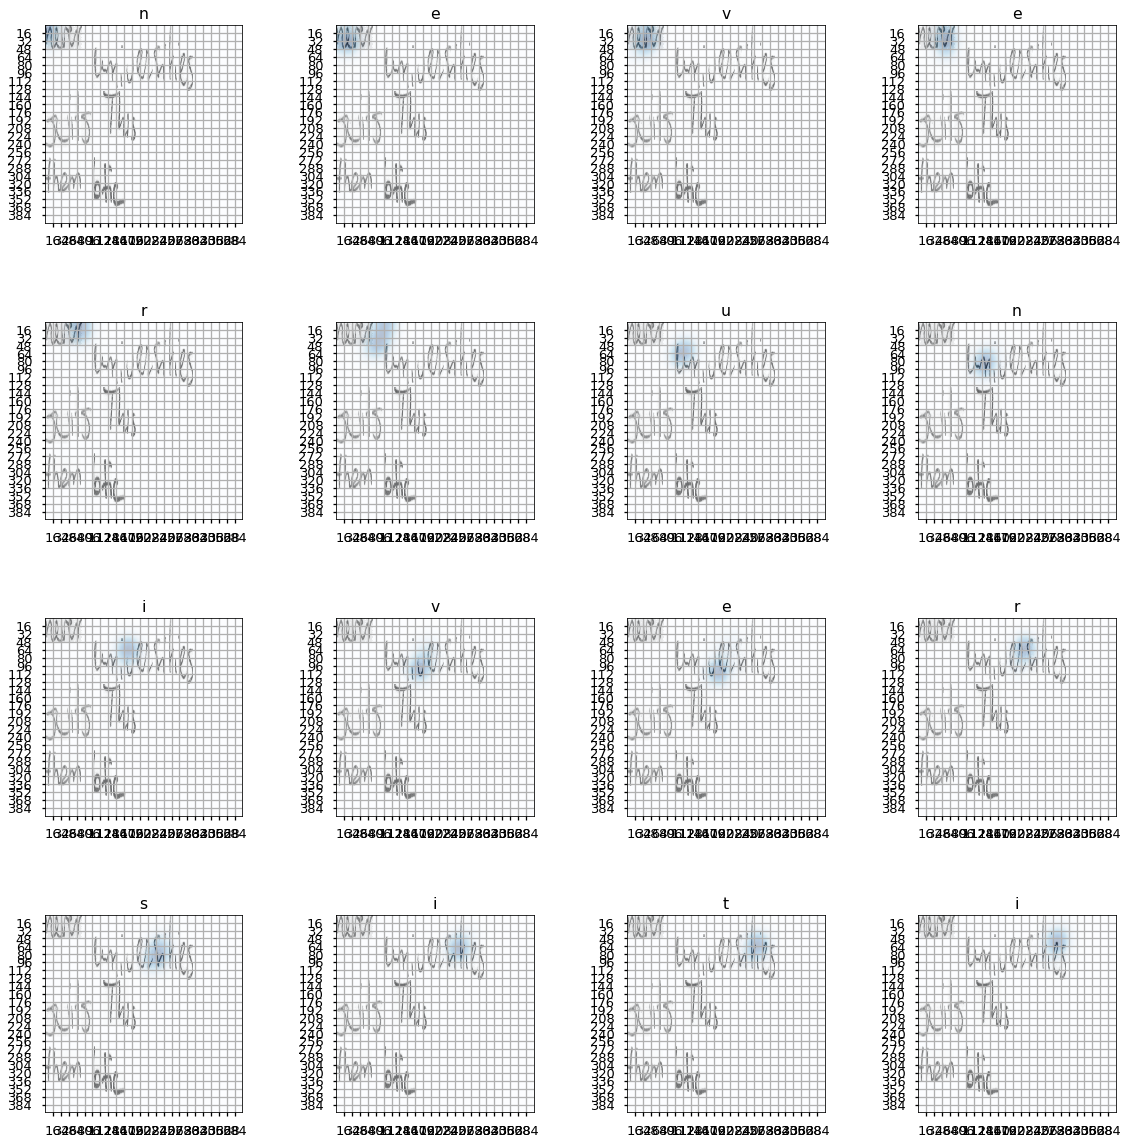

In [124]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20), gridspec_kw={'hspace': 0.5})
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    
    # Attention
    ticks = np.arange(k, sz, k)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

## self-attn

Decoder Self Layer 1


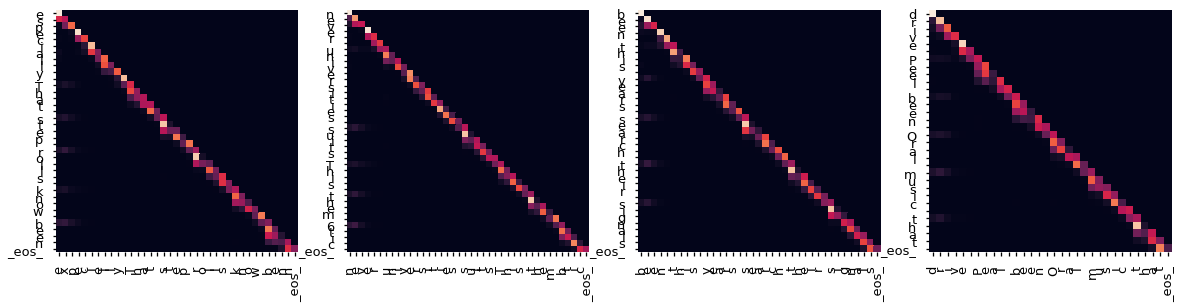

Decoder Self Layer 2


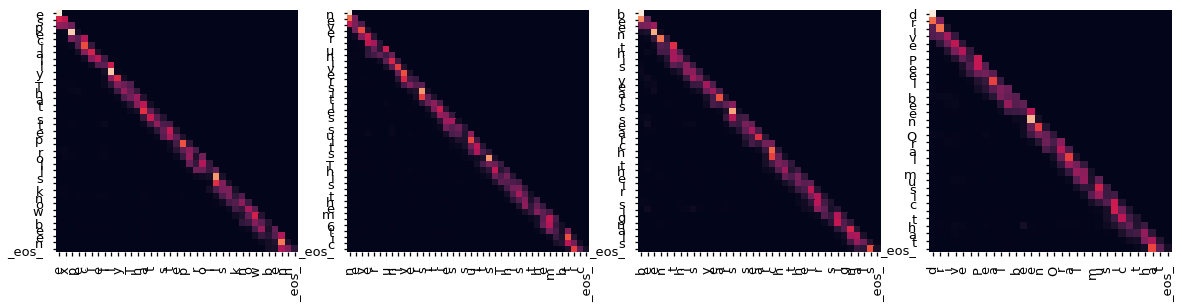

In [125]:
sns.set_context(context="talk")

def draw(data, x, y, ax):
    sns.heatmap(data, xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, cbar=False, ax=ax)

h = 0  #attn head
for layer in range(2):
    print("Decoder Self Layer", layer+1)
    fig, axes = plt.subplots(1,4, figsize=(20, 10))
    for i,ax in enumerate(axes.flat):  # multi example
        pred = char_split_text(res[i])
        true = char_split_text(y[i])
        draw(self_attn(layer)[i,h].data[:len(true), :len(true)], pred, true, ax=ax)
    plt.show()

### Check memory

In [49]:
def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

In [51]:
dump_tensors()

Total size: 0


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: RangeIndex.data is deprecated and will be removed in a future version
  
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Index.data is deprecated and will be removed in a future version
  
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Int64Index.data is deprecated and will be removed in a future version
  


# Training

This section describes the training regime for our models.

## Batches and Masking

In [ ]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

> Next we create a generic training and scoring function to keep track of loss. We pass in a generic loss compute function that also handles parameter updates. 

## Training Loop

In [44]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" % (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## Training Data and Batching

We trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs.  Sentences were encoded using byte-pair encoding, which has a shared source-target vocabulary of about 37000 tokens. For English-French, we used the significantly larger WMT 2014 English-French dataset consisting of 36M sentences and split tokens into a 32000 word-piece vocabulary.


Sentence pairs were batched together by approximate sequence length.  Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens.     

> We will use torch text for batching. This is discussed in more detail below. Here we create batches in a torchtext function that ensures our batch size padded to the maximum batchsize does not surpass a threshold (25000 if we have 8 gpus).

In [45]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

## Hardware and Schedule                                                                                                                                                                                                   
We trained our models on one machine with 8 NVIDIA P100 GPUs.  For our base models using the hyperparameters described throughout the paper, each training step took about 0.4 seconds.  We trained the base models for a total of 100,000 steps or 12 hours. For our big models, step time was 1.0 seconds.  The big models were trained for 300,000 steps (3.5 days).

## Optimizer

We used the Adam optimizer [(cite)](https://arxiv.org/abs/1412.6980) with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$.  We varied the learning rate over the course of training, according to the formula:                                                                                            
$$                                                                                                                                                                                                                                                                                         
lrate = d_{\text{model}}^{-0.5} \cdot                                                                                                                                                                                                                                                                                                
  \min({step\_num}^{-0.5},                                                                                                                                                                                                                                                                                                  
    {step\_num} \cdot {warmup\_steps}^{-1.5})                                                                                                                                                                                                                                                                               
$$                                                                                                                                                                                             
This corresponds to increasing the learning rate linearly for the first $warmup\_steps$ training steps, and decreasing it thereafter proportionally to the inverse square root of the step number.  We used $warmup\_steps=4000$.                            

> Note: This part is very important. Need to train with this setup of the model. 

In [67]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

## Regularization                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                                                                                                      
### Label Smoothing

During training, we employed label smoothing of value $\epsilon_{ls}=0.1$ [(cite)](https://arxiv.org/abs/1512.00567).  This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.  

> We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution, we create a distribution that has `confidence` of the correct word and the rest of the `smoothing` mass distributed throughout the vocabulary.

In [51]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum') #(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if len(mask) > 0:
#         if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

> Here we can see an example of how the mass is distributed to the words based on confidence. 

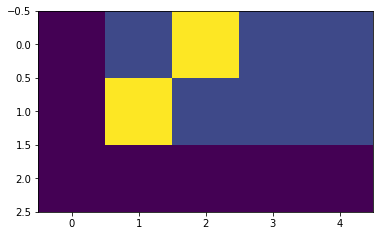

In [48]:
#Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

> Label smoothing actually starts to penalize the model if it gets very confident about a given choice. 

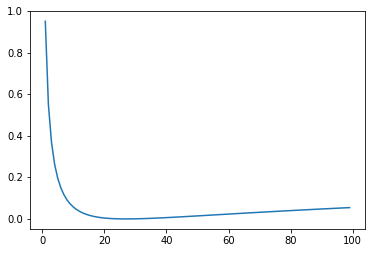

In [52]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    #print(predict)
    return crit(Variable(predict.log()), Variable(torch.LongTensor([1]))).item()

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

# A First  Example

> We can begin by trying out a simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols. 

## Synthetic Data

In [54]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

## Loss Computation

In [55]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm.float()
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

## Greedy Decoding

In [ ]:
# Train the simple copy task.
V = 11  #len of vocab - sl
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, SimpleLossCompute(model.generator, criterion, None)))

Epoch Step: 1 Loss: 3.000000 Tokens per Sec: 540.000000


> This code predicts a translation using greedy decoding for simplicity. 

In [53]:
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src.shape

torch.Size([1, 10])

In [33]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, Variable(ys), Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))


    1     2     3     4     5     6     7     8     9    10
[torch.LongTensor of size 1x10]



# A Real World Example

> Now we consider a real-world example using the IWSLT German-English Translation task. This task is much smaller than the WMT task considered in the paper, but it illustrates the whole system. We also show how to use multi-gpu processing to make it really fast.

In [34]:
#!pip install torchtext spacy
#!python -m spacy download en
#!python -m spacy download de

## Data Loading
> We will load the dataset using torchtext and spacy for tokenization. 

In [42]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                     eos_token = EOS_WORD, pad_token=BLANK_WORD)

    MAX_LEN = 100
    train, val, test = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TGT), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 2
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

> Batching matters a ton for speed. We want to have very evenly divided batches, with absolutely minimal padding. To do this we have to hack a bit around the default torchtext batching. This code patches their default batching to make sure we search over enough sentences to find tight batches. 

## Iterators

In [36]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

## Multi-GPU Training

> Finally to really target fast training, we will use multi-gpu. This code implements multi-gpu word generation. It is not specific to transformer so I won't go into too much detail. The idea is to split up word generation at training time into chunks to be processed in parallel across many different gpus. We do this using pytorch parallel primitives:

* replicate - split modules onto different gpus.
* scatter - split batches onto different gpus
* parallel_apply - apply module to batches on different gpus
* gather - pull scattered data back onto one gpu. 
* nn.DataParallel - a special module wrapper that calls these all before evaluating. 


In [37]:
# Skip if not interested in multigpu.
class MultiGPULossCompute:
    "A multi-gpu loss compute and train function."
    def __init__(self, generator, criterion, devices, opt=None, chunk_size=5):
        # Send out to different gpus.
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, 
                                               devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size
        
    def __call__(self, out, targets, normalize):
        total = 0.0
        generator = nn.parallel.replicate(self.generator, 
                                                devices=self.devices)
        out_scatter = nn.parallel.scatter(out, 
                                          target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets, 
                                      target_gpus=self.devices)

        # Divide generating into chunks.
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            # Predict distributions
            out_column = [[Variable(o[:, i:i+chunk_size].data, 
                                    requires_grad=self.opt is not None)] 
                           for o in out_scatter]
            gen = nn.parallel.parallel_apply(generator, out_column)

            # Compute loss. 
            y = [(g.contiguous().view(-1, g.size(-1)), 
                  t[:, i:i+chunk_size].contiguous().view(-1)) 
                 for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)

            # Sum and normalize loss
            l = nn.parallel.gather(loss, 
                                   target_device=self.devices[0])
            l = l.sum()[0] / normalize
            total += l.data[0]

            # Backprop loss to output of transformer
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())

        # Backprop all loss through transformer.            
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, 
                                    target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

> Now we create our model, criterion, optimizer, data iterators, and paralelization

In [43]:
# GPUs to use
devices = [0, 1, 2, 3]
if True:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion.cuda()
    BATCH_SIZE = 12000
    train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)
    model_par = nn.DataParallel(model, device_ids=devices)
None

> Now we train the model. I will play with the warmup steps a bit, but everything else uses the default parameters.  On an AWS p3.8xlarge with 4 Tesla V100s, this runs at ~27,000 tokens per second with a batch size of 12,000 

## Training the System

In [12]:
#!wget https://s3.amazonaws.com/opennmt-models/iwslt.pt

In [44]:
if False:
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(10):
        model_par.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), 
                  model_par, 
                  MultiGPULossCompute(model.generator, criterion, 
                                      devices=devices, opt=model_opt))
        model_par.eval()
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), 
                          model_par, 
                          MultiGPULossCompute(model.generator, criterion, 
                          devices=devices, opt=None))
        print(loss)
else:
    model = torch.load("iwslt.pt")

> Once trained we can decode the model to produce a set of translations. Here we simply translate the first sentence in the validation set. This dataset is pretty small so the translations with greedy search are reasonably accurate. 

In [45]:
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    break

Translation:	<unk> <unk> . In my language , that means , thank you very much . 
Target:	<unk> <unk> . It means in my language , thank you very much . 


# Additional Components: BPE, Search, Averaging

> So this mostly covers the transformer model itself. There are four aspects that we didn't cover explicitly. We also have all these additional features implemented in [OpenNMT-py](https://github.com/opennmt/opennmt-py).



> 1) BPE/ Word-piece: We can use a library to first preprocess the data into subword units. See Rico Sennrich's [subword-nmt](https://github.com/rsennrich/subword-nmt) implementation. These models will transform the training data to look like this:

▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden .

> 2) Shared Embeddings: When using BPE with shared vocabulary we can share the same weight vectors between the source / target / generator. See the [(cite)](https://arxiv.org/abs/1608.05859) for details. To add this to the model simply do this:

In [ ]:
if False:
    model.src_embed[0].lut.weight = model.tgt_embeddings[0].lut.weight
    model.generator.lut.weight = model.tgt_embed[0].lut.weight

> 3) Beam Search: This is a bit too complicated to cover here. See the [OpenNMT-py](https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/translate/Beam.py) for a pytorch implementation.



> 4) Model Averaging: The paper averages the last k checkpoints to create an ensembling effect. We can do this after the fact if we have a bunch of models:

In [ ]:
def average(model, models):
    "Average models into model"
    for ps in zip(*[m.params() for m in [model] + models]):
        p[0].copy_(torch.sum(*ps[1:]) / len(ps[1:]))

# Results

On the WMT 2014 English-to-German translation task, the big transformer model (Transformer (big)
in Table 2) outperforms the best previously reported models (including ensembles) by more than 2.0
BLEU, establishing a new state-of-the-art BLEU score of 28.4. The configuration of this model is
listed in the bottom line of Table 3. Training took 3.5 days on 8 P100 GPUs. Even our base model
surpasses all previously published models and ensembles, at a fraction of the training cost of any of
the competitive models.

On the WMT 2014 English-to-French translation task, our big model achieves a BLEU score of 41.0,
outperforming all of the previously published single models, at less than 1/4 the training cost of the
previous state-of-the-art model. The Transformer (big) model trained for English-to-French used
dropout rate Pdrop = 0.1, instead of 0.3.

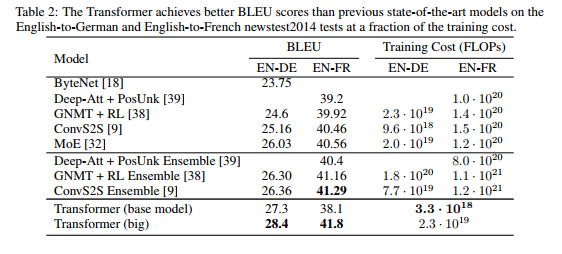

In [10]:
Image(filename="images/results.png")

> The code we have written here is a version of the base model. There are fully trained version of this system available here  [(Example Models)](http://opennmt.net/Models-py/).
>
> With the addtional extensions in the last section, the OpenNMT-py replication gets to 26.9 on EN-DE WMT. Here I have loaded in those parameters to our reimplemenation. 

In [ ]:
!wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt

In [46]:
model, SRC, TGT = torch.load("en-de-model.pt")

In [49]:
model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TGT.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

Translation:	<s> ▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden . 


## Attention Visualization

> Even with a greedy decoder the translation looks pretty good. We can further visualize it to see what is happening at each layer of the attention 

Encoder Layer 2


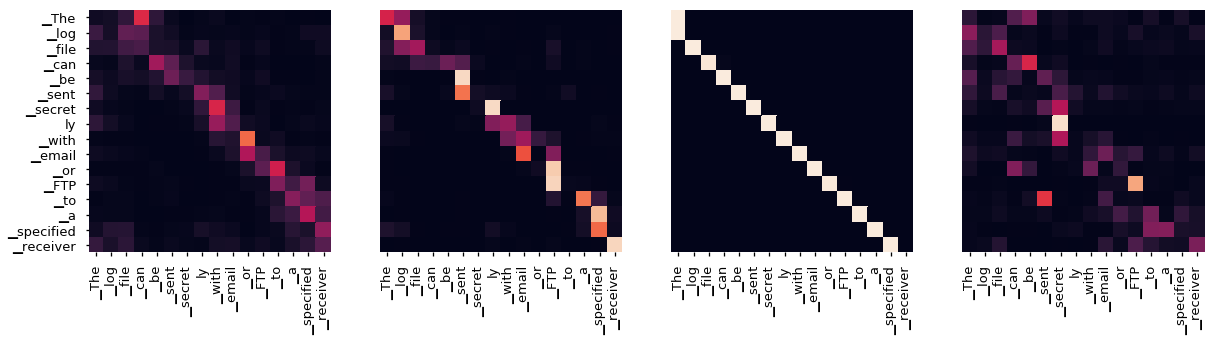

Encoder Layer 4


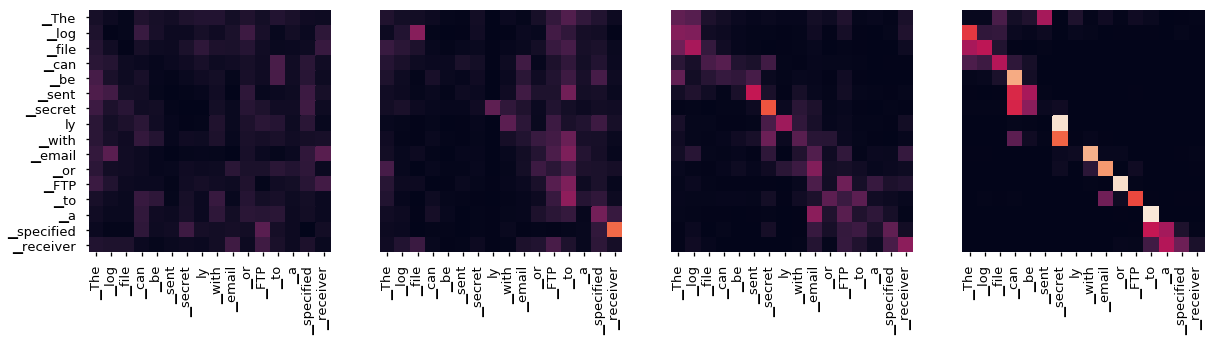

Encoder Layer 6


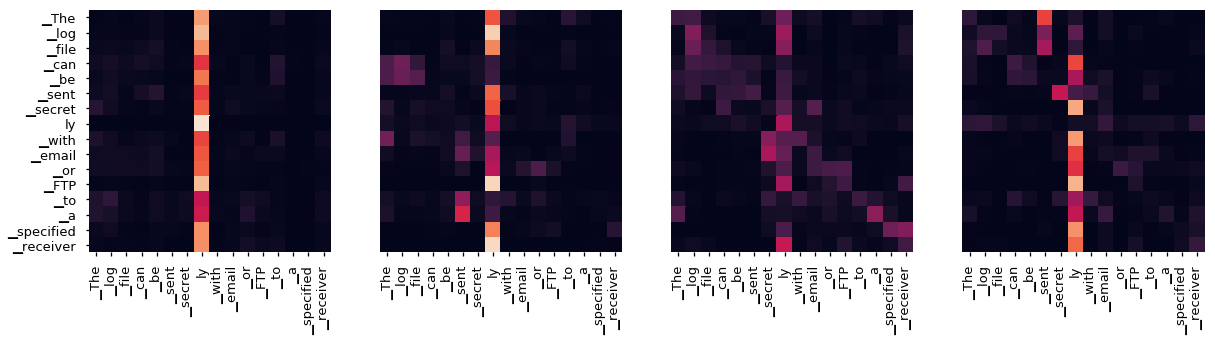

Decoder Self Layer 2


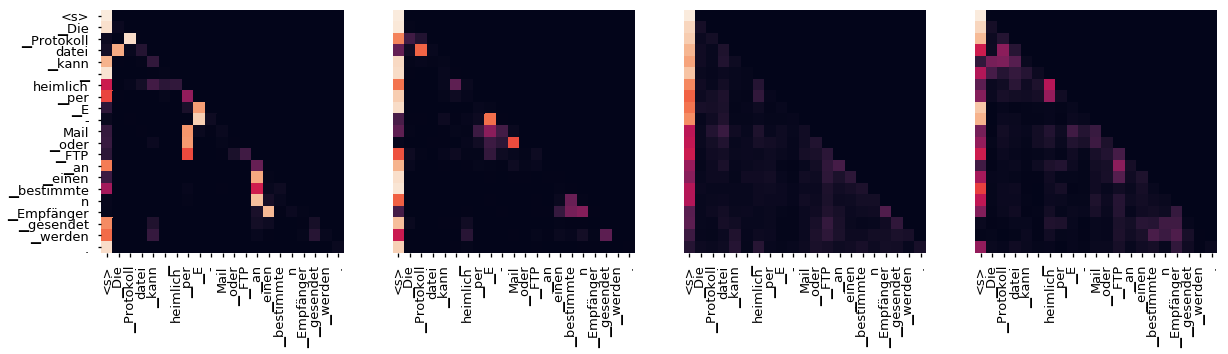

Decoder Src Layer 2


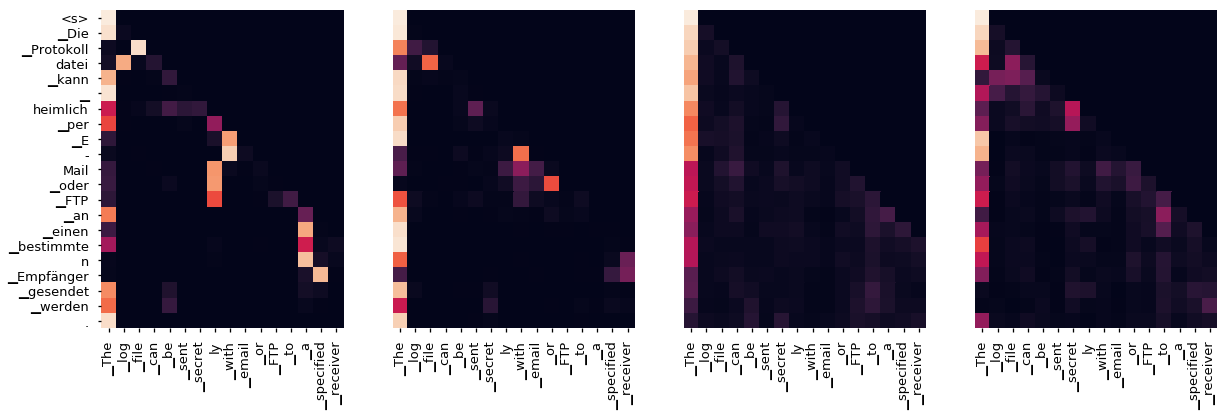

Decoder Self Layer 4


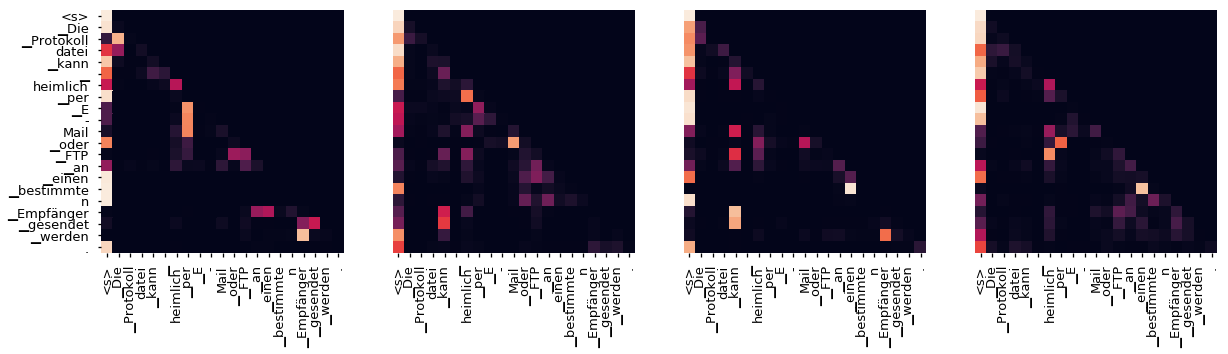

Decoder Src Layer 4


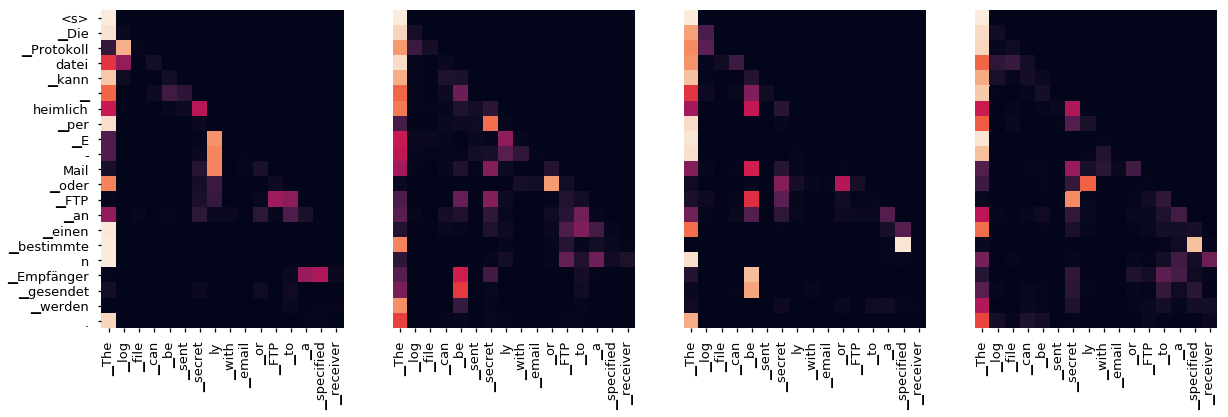

Decoder Self Layer 6


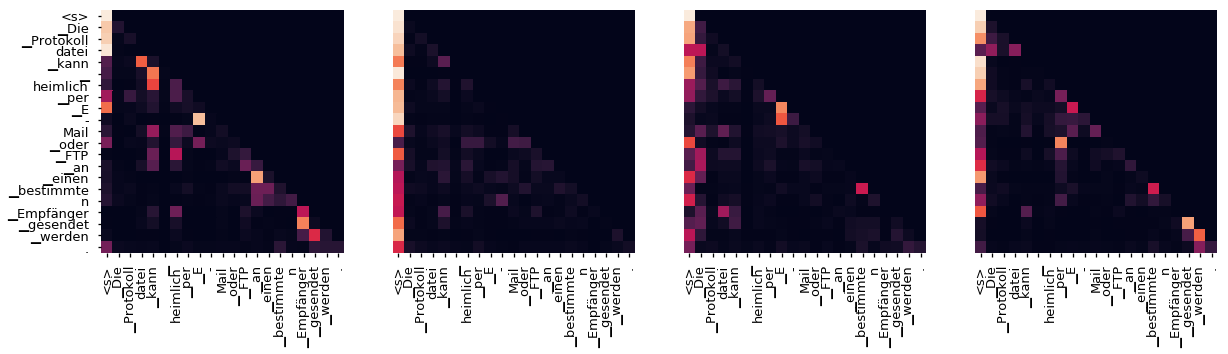

Decoder Src Layer 6


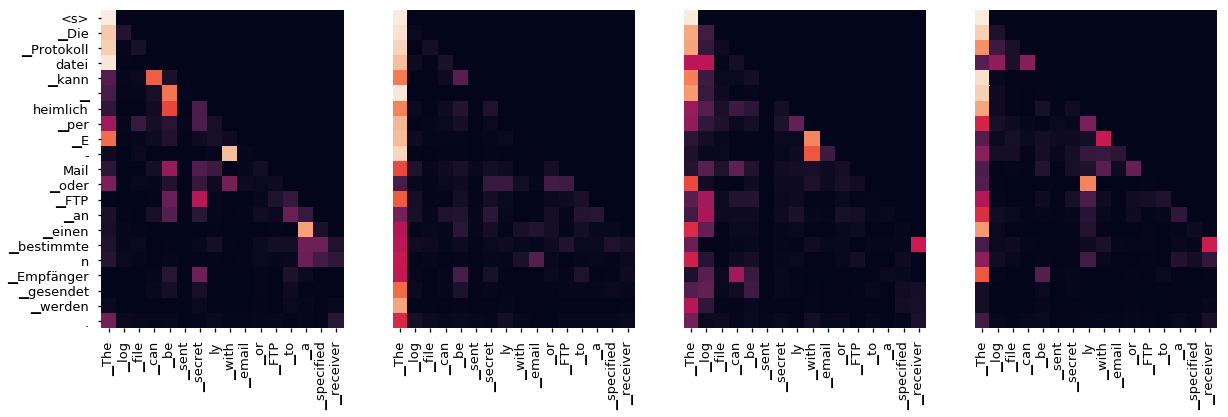

In [50]:
tgt_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()


<div id="disqus_thread"></div>
<script>
    /**
     *  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
     *  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
     */
    /*
    var disqus_config = function () {
        this.page.url = PAGE_URL;  // Replace PAGE_URL with your page's canonical URL variable
        this.page.identifier = PAGE_IDENTIFIER; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
    };
    */
    (function() {  // REQUIRED CONFIGURATION VARIABLE: EDIT THE SHORTNAME BELOW
        var d = document, s = d.createElement('script');
        
        s.src = 'https://EXAMPLE.disqus.com/embed.js';  // IMPORTANT: Replace EXAMPLE with your forum shortname!
        
        s.setAttribute('data-timestamp', +new Date());
        (d.head || d.body).appendChild(s);
    })();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript" rel="nofollow">comments powered by Disqus.</a></noscript>